In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

# Basic stats

In [4]:
# Analysis by Sangjin here: https://github.com/regevs/sperm/issues/54#issuecomment-2587179795

In [6]:
flow_cell_stats_df = (
    pl.read_csv(
        "/lustre/scratch122/tol/projects/sperm/analysis/sequence_throughput/sequence_throughput_per_movie.csv"
    )
    .with_columns(
        sample_id = pl.col("Sample"),
        coverage = pl.col("Coverage").cast(pl.Float64),
        count = pl.col("Read count").cast(pl.Int64),
        mean = pl.col("Mean length (bp)").str.split(by=' ± ').list.first().cast(pl.Float64),
    )
)


### Filter for only the used samples

In [7]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

CEPH_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/CEPH.tsv", separator='\t')


In [8]:
unique_ids = pl.concat([
    rahbari_df["flow_cell"],
    sudmant_df["flow_cell"],
    CEPH_df["flow_cell"],
    flow_cell_stats_df.filter(pl.col("Sample").is_in(["PD47269d", "PD48473b"]))["Movie"],   # Campbell blood samples
]).unique()

In [9]:
stats_df = (flow_cell_stats_df.filter(pl.col("Movie").is_in(unique_ids)))

## Read coverage

In [23]:
coverage_per_sample = stats_df.group_by("sample_id").agg(pl.col("coverage").sum())

In [29]:
print("Average coverage:", coverage_per_sample["coverage"].mean())

Average coverage: 57.687878787878766


In [30]:
print("Range coverage:", coverage_per_sample["coverage"].min(), coverage_per_sample["coverage"].max())

Range coverage: 17.25 159.14000000000001


## Get read counts

In [31]:
print("Total number of reads (before any processing):", stats_df["count"].sum())

Total number of reads (before any processing): 403873298


In [34]:
print("Total number of reads (before any processing), Rahbari sperm:", stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids))["count"].sum())

Total number of reads (before any processing), Rahbari sperm: 219381164


In [36]:
print("Total number of reads (before any processing), Sudmant sperm:", stats_df.filter(pl.col("sample_id").is_in(sudmant_sample_ids))["count"].sum())
      

Total number of reads (before any processing), Sudmant sperm: 48080396


In [37]:
print("Total number of reads (before any processing), total sperm:", 
    stats_df.filter(pl.col("sample_id").is_in(rahbari_sample_ids + sudmant_sample_ids))["count"].sum()
)

Total number of reads (before any processing), total sperm: 267461560


In [40]:
print("Total number of reads (before any processing), Campbell blood:", 
    stats_df.filter(pl.col("sample_id").is_in(["PD47269d", "PD48473b"]))["count"].sum()
)

Total number of reads (before any processing), Campbell blood: 17609178


In [41]:
stats_df

Sample,Movie,Instrument,Read count,Total bases (bp),Coverage,Min length (bp),Max length (bp),Mean length (bp),sample_id,coverage,count,mean
str,str,str,i64,i64,f64,i64,i64,str,str,f64,i64,f64
"""NA12892""","""m64076_230314_050530""","""Sequel_IIe""",1903236,42498218211,14.17,130,71008,"""22329.45 ± 5330.30""","""NA12892""",14.17,1903236,22329.45
"""NA12892""","""m64076_230312_191745""","""Sequel_IIe""",1816654,40721362500,13.57,123,71072,"""22415.59 ± 5348.91""","""NA12892""",13.57,1816654,22415.59
"""NA12892""","""m64076_230311_094742""","""Sequel_IIe""",1928257,43286410511,14.43,229,68629,"""22448.47 ± 5400.85""","""NA12892""",14.43,1928257,22448.47
"""200102""","""m84039_230404_000434_s2""","""Revio""",5769906,68837455415,22.95,98,60028,"""11930.43 ± 5186.63""","""200102""",22.95,5769906,11930.43
"""200102""","""m84039_230401_024513_s2""","""Revio""",3617233,47973487472,15.99,94,55331,"""13262.48 ± 5428.45""","""200102""",15.99,3617233,13262.48
…,…,…,…,…,…,…,…,…,…,…,…,…
"""PD47269d""","""m64125_201110_063134""","""Sequel_IIe""",1281350,25051474356,8.35,48,44509,"""19550.84 ± 2346.37""","""PD47269d""",8.35,1281350,19550.84
"""PD47269d""","""m64089_201023_192624""","""Sequel_IIe""",415249,8039261298,2.68,45,36075,"""19360.10 ± 2283.80""","""PD47269d""",2.68,415249,19360.1
"""PD48473b""","""m64125_201018_191043""","""Sequel_IIe""",1850245,33756262973,11.25,47,41622,"""18244.21 ± 1748.30""","""PD48473b""",11.25,1850245,18244.21


In [43]:
print("Total number of reads (before any processing), CEPH blood:", 
    stats_df.filter(pl.col("sample_id").is_in(CEPH_df["sample_id"]))["count"].sum()
)

Total number of reads (before any processing), CEPH blood: 118802560


In [47]:
print("Average read length:", (stats_df["mean"] * stats_df["count"]).sum() / stats_df["count"].sum())

Average read length: 14140.498300025518


# Get read counts after filtering

In [70]:
%%time
reads_df = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)


9it [00:00, 1021.28it/s]

6it [00:00, 2544.57it/s]

CPU times: user 24.3 ms, sys: 14.8 ms, total: 39.2 ms
Wall time: 21.9 ms


In [71]:
(reads_df
    .filter(pl.col("is_high_quality_read"))
    .select(pl.len())
).collect()

len
u32
196296004


# Number of SNPs

In [73]:
%%time
all_snps = pl.concat(
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        pl.scan_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
        ) 
        for sample_id, sample_set, flow_cell in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set", "flow_cell").iter_rows())
        for chrom in aut_chrom_names
    ]
)


56it [00:00, 3554.01it/s]
12it [00:00, 4195.70it/s]

CPU times: user 24.7 ms, sys: 3.37 ms, total: 28 ms
Wall time: 26.2 ms


In [74]:
%%time
all_snps.select(pl.len()).collect()

CPU times: user 2.95 s, sys: 2.55 s, total: 5.5 s
Wall time: 1min 13s


len
u32
3021086931


In [79]:
%%time
all_snps.select("read_name", "start", "is_high_quality_snp").collect().filter("is_high_quality_snp").select(pl.len())

CPU times: user 1min 19s, sys: 38.1 s, total: 1min 57s
Wall time: 8.45 s


len
u32
1163633539


## High quality SNPs per read

In [81]:
rows = []

for sample_id, sample_set, flow_cell in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set", "flow_cell").iter_rows()):
    for chrom in aut_chrom_names:        
        sample_snps = \
            pl.scan_parquet(
                f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
            ) 

        unique_snp_counts = (sample_snps
            .filter("is_high_quality_snp")
            .group_by("read_name")
            .len().rename({"len": "n_snps"})
            .group_by("n_snps")
            .len()
            .collect(streaming=True)
        )
        rows.append((sample_id, sample_set, flow_cell, chrom, unique_snp_counts))
        
for sample_id, sample_set, flow_cell in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set", "flow_cell").iter_rows()):
    for chrom in aut_chrom_names:        
        sample_snps = \
            pl.scan_parquet(
                f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/{flow_cell}/{chrom}/annotated_0.95_high_confidence_snps.parquet",
            ) 

        unique_snp_counts = (sample_snps
            .filter("is_high_quality_snp")
            .group_by("read_name")
            .len().rename({"len": "n_snps"})
            .group_by("n_snps")
            .len()
            .collect(streaming=True)
        )
        rows.append((sample_id, sample_set, flow_cell, chrom, unique_snp_counts))        

56it [01:49,  1.96s/it]
12it [00:30,  2.53s/it]


In [85]:
total_hist = {s:np.zeros(400) for s in sample_ids + ["All"]}
for row in rows:
    for n_snps, cnt in row[-1].rows():
        total_hist[row[0]][n_snps] += cnt
        total_hist["All"][n_snps] += cnt

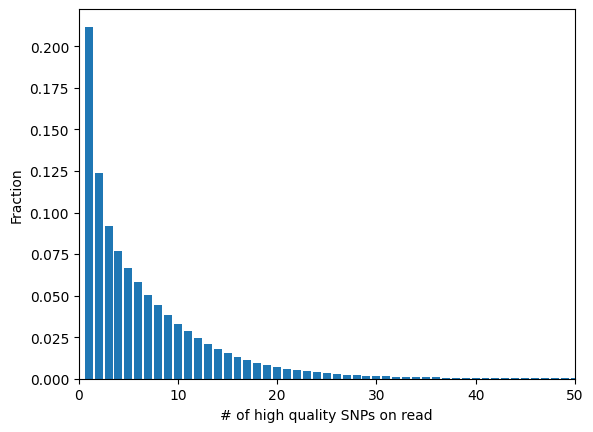

In [86]:
plt.bar(x=np.arange(400), height=total_hist["All"] / total_hist["All"].sum())
plt.xlim(0, 50)
plt.xlabel("# of high quality SNPs on read");
plt.ylabel("Fraction");

In [87]:
for k,T in total_hist.items():
    print(k, np.sum([i*h for i, h in enumerate(T)]) / np.sum(T))

PD50477f 5.759972152944968
PD50519d 5.909671306833053
PD50508f 8.121031856311262
PD50523b 6.292058776310657
PD50521b 6.288746222095818
PD50508b 6.791652024049477
PD46180c 6.169597220184443
PD50521e 5.157612829351835
PD50489e 5.638578126174709
1894 9.209768567361532
3898 9.94499472871258
7899 9.288745167615568
95619 9.050880538177411
115980 9.337350353758193
2895 9.651255895471687
All 6.699282020135253


# Candidate read classes

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')

In [6]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

9it [00:00, 1003.37it/s]


CPU times: user 52.7 ms, sys: 210 ms, total: 263 ms
Wall time: 10.5 s


len
u32
50653


In [7]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

6it [00:00, 2520.87it/s]


CPU times: user 25.8 ms, sys: 62.9 ms, total: 88.8 ms
Wall time: 260 ms


len
u32
14793


In [92]:
50653 + 14793

65446

In [93]:
# %%time
# (
#     pl.concat([
#         pl.scan_parquet(
#             f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/classified_reads.parquet",
#         ) 
#         for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
#         for chrom in aut_chrom_names
#     ]).select("class", "sample_id").collect()
#         .pivot(
#             values=["class"],
#             index=["sample_id"],
#             on=["class"],
#             aggregate_function='len'
#         )
#         .sort(by="sample_id")
#         .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
# )

In [8]:
%%time
rahbari_reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
])

9it [00:00, 2735.42it/s]

CPU times: user 7.74 ms, sys: 755 μs, total: 8.5 ms
Wall time: 6.27 ms


In [9]:
%%time
sudmant_reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet",
    ) 
    for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
    for chrom in aut_chrom_names
])

6it [00:00, 2543.80it/s]

CPU times: user 5.52 ms, sys: 247 μs, total: 5.77 ms
Wall time: 4.22 ms


In [10]:
reads_df = pl.concat([rahbari_reads_df, sudmant_reads_df])

In [11]:
%%time
candidates_df = (reads_df
    .select(
        'read_name',
        'chrom',
        'sample_id',
        'is_high_quality_read',
        "high_quality_classification_class",
        "high_quality_classification_in_detectable_class",
        'grch37_reference_start',
        'grch38_reference_start',
        'T2T_reference_start',
        "mid_quality_snp_positions",
        "mid_quality_snp_positions_alleles",
        "total_mismatches",
        "is_contamination",
    )
    .filter("is_high_quality_read")
    .filter(~pl.col("is_contamination"))
    .filter(pl.col("high_quality_classification_class").is_not_null())
    .collect(streaming=True)
)

CPU times: user 4min 32s, sys: 1min, total: 5min 32s
Wall time: 7min 13s


In [14]:
len(candidates_df)

17335

In [16]:
call_stats_df = (candidates_df    
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        on=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
    .sort(by="sample_id")
)

with pl.Config(tbl_rows=40):
    display(call_stats_df)

    display(call_stats_df.sum())
# call_stats_df = (
#     pl.DataFrame(
#         {
#             "sample_id": sample_presentation_order, 
#             "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
#         }
#     )
#     .join(call_stats_df, on="sample_id")
# )

# with pl.Config(tbl_rows=40):
#     display(call_stats_df.drop("sample_id"))

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""115980""",365,129,299,5
"""1894""",433,159,341,5
"""2895""",330,112,260,7
"""3898""",380,161,293,5
"""7899""",427,152,334,6
"""95619""",395,123,319,7
"""PD46180c""",740,208,756,26
"""PD50477f""",714,192,1174,10
"""PD50489e""",499,137,522,18


sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
null,7143,2388,7585,219


In [42]:
rahbari_candidates_extended_df = (candidates_df
    .join(rahbari_reads_flow_cells_df, on=["read_name", "sample_id"])
    .join(rahbari_df.select("sample_id", "flow_cell", "flow_cell_type"), on=["sample_id", "flow_cell"])
)

In [80]:
with pl.Config(tbl_rows=100):
    for sample_id in rahbari_sample_ids:
        subdf = (rahbari_candidates_extended_df
            .filter(pl.col("sample_id") == sample_id)
            .pivot(
                values=["high_quality_classification_class"],
                index=["flow_cell_type"],
                on=["high_quality_classification_class"],
                aggregate_function='len'
            )
            .sort("flow_cell_type")
            .fill_null(0)    
        )
        print(sample_id, "chi2 p-value:", scipy.stats.chi2_contingency(subdf.drop("flow_cell_type")).pvalue)
        display(subdf)

PD50477f chi2 p-value: 2.2175349947744808e-41


flow_cell_type,ambiguous,CO,CNCO,GC
str,u32,u32,u32,u32
"""revio_unbinned""",1141,603,8,159
"""sequel_ii""",79,149,22,54


PD50519d chi2 p-value: 6.185889304311392e-44


flow_cell_type,ambiguous,CNCO,CO,GC
str,u32,u32,u32,u32
"""revio_unbinned""",894,23,603,133
"""sequel_ii""",71,35,131,75


PD50508f chi2 p-value: 1.0


flow_cell_type,ambiguous,CO,GC,CNCO
str,u32,u32,u32,u32
"""sequel_ii""",100,122,31,7


PD50523b chi2 p-value: 6.402129788415525e-29


flow_cell_type,CO,CNCO,ambiguous,GC
str,u32,u32,u32,u32
"""revio_unbinned""",830,837,1385,812
"""sequel_ii""",138,11,80,47


PD50521b chi2 p-value: 0.12894967834472304


flow_cell_type,CO,GC,CNCO,ambiguous
str,u32,u32,u32,u32
"""revio_unbinned""",92,45,21,116
"""sequel_ii""",202,71,50,180


PD50508b chi2 p-value: 4.957063241185455e-07


flow_cell_type,GC,CNCO,ambiguous,CO
str,u32,u32,u32,u32
"""revio_unbinned""",75,6,315,268
"""sequel_ii""",41,0,69,138


PD46180c chi2 p-value: 1.3193948521082313e-07


flow_cell_type,ambiguous,CO,GC,CNCO
str,u32,u32,u32,u32
"""revio_unbinned""",741,604,270,215
"""sequel_ii""",113,189,52,36


PD50521e chi2 p-value: 9.639683649822777e-05


flow_cell_type,CO,ambiguous,GC,CNCO
str,u32,u32,u32,u32
"""revio_unbinned""",457,479,171,22
"""sequel_ii""",160,120,59,21


PD50489e chi2 p-value: 6.774959943116623e-09


flow_cell_type,CO,ambiguous,CNCO,GC
str,u32,u32,u32,u32
"""revio_unbinned""",386,499,34,133
"""sequel_ii""",136,68,17,35


In [67]:
scipy.stats.fisher_exact([[71, 894], [35, 25]])

SignificanceResult(statistic=np.float64(0.056727388942154046), pvalue=np.float64(8.525583323071718e-22))

### Remove bad reads from manual inspection

In [15]:
call_stats_df = (candidates_df 
    .filter(~pl.col("read_name").is_in(
        control_CO_read_blacklist_PD47269d + control_ambiguous_read_blacklist_PD47269d + \
        control_CO_read_blacklist_PD48473b + control_ambiguous_read_blacklist_PD48473b + \
        control_NCO_read_blacklist_PD48473b + control_complex_read_blacklist_PD48473b
    ))
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        columns=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
)

with pl.Config(tbl_rows=40):
    display(call_stats_df)

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""PD47269d""",2,20,7,22
"""PD48473b""",2,19,3,2


In [31]:
(10/(70.2+30.1))/(3019/525.5)*100

1.735436288022319

In [30]:
(39/(70.2+30.1))/(1759/525.5)*100

11.61637316589175

In [32]:
(24/(70.2+30.1))/(351/525.5)*100

35.82415147719235

# Save to xls file

In [10]:
(candidates_df
    .rename({
        "high_quality_classification_class": "event_type",
        "mid_quality_snp_positions": "snp_positions",
        "mid_quality_snp_positions_alleles": "snp_alleles",
    })
    .join(
        pl.DataFrame({
            "sample_id": sample_id_to_paper_label.keys(),
            "label": sample_id_to_paper_label.values(),
        }),
        on="sample_id",
    )
    .with_columns(
        event_type = pl.col("event_type").replace(["GC", "CNCO"], ["NCO", "complex"])
    )
    .sort(["label", "chrom"])
    [[
        "label", 
        "chrom",
        "event_type",
        'grch37_reference_start',
        'grch38_reference_start',
        'T2T_reference_start',
        "snp_positions",
        "snp_alleles",
    ]]
    .write_excel("/nfs/users/nfs_r/rs42/rs42/git/sperm/recombination_events.xlsx")
)

label,chrom,event_type,grch37_reference_start,grch38_reference_start,T2T_reference_start,snp_positions,snp_alleles
str,str,str,i64,i64,i64,list[i64],list[i32]
"""AA1-s1""","""chr1""","""ambiguous""",null,null,2100359,"[5909, 9819]","[1, 0]"
"""AA1-s1""","""chr1""","""ambiguous""",15683211,15356715,14801362,"[3219, 3622]","[0, 1]"
"""AA1-s1""","""chr1""","""ambiguous""",7498222,7438162,6967580,"[937, 1868, … 11555]","[1, 1, … 0]"
"""AA1-s1""","""chr1""","""NCO""",201103101,201133973,200390958,"[1452, 1485, … 12704]","[0, 0, … 0]"
"""AA1-s1""","""chr1""","""NCO""",102272811,101807255,101656442,"[1135, 1313, … 14413]","[0, 0, … 0]"
…,…,…,…,…,…,…,…
"""AN-s2""","""chr9""","""CO""",1071929,1071929,1073619,"[1764, 2728, … 31017]","[1, 1, … 0]"
"""AN-s2""","""chr9""","""NCO""",514745,514745,514218,"[869, 1665, … 6137]","[0, 0, … 0]"
"""AN-s2""","""chr9""","""NCO""",469892,469892,469385,"[1574, 2699, … 11464]","[0, 0, … 0]"


In [44]:
call_stats_df = (candidates_df
    .with_columns(
        combined_class = pl.when(
            pl.col("high_quality_classification_class") == "CNCO"
        ).then(
            pl.lit("Complex")
        ).when(
            pl.col("high_quality_classification_in_detectable_class").is_not_null()
        ).then(
            "high_quality_classification_in_detectable_class"
        ).otherwise(
            pl.lit("Ambiguous")
        )
    )
    .pivot(
        values=["combined_class"],
        index=["sample_id"],
        columns=["combined_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "NCO", "Ambiguous", "Complex")
)

# call_stats_df = (
#     pl.DataFrame(
#         {
#             "sample_id": sample_presentation_order, 
#             "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
#         }
#     )
#     .join(call_stats_df, on="sample_id")
# )
with pl.Config(tbl_rows=40):
    display(call_stats_df)

sample_id,CO,NCO,Ambiguous,Complex
str,u32,u32,u32,u32
"""PD47269d""",14,15,81,22
"""PD48473b""",6,15,47,3


In [43]:
(candidates_df
    .group_by("high_quality_classification_class", "high_quality_classification_in_detectable_class")
    .len()
    .sort("len")
)

high_quality_classification_class,high_quality_classification_in_detectable_class,len
str,str,u32
"""CNCO""","""CO""",7
"""GC""","""CO""",16
"""CNCO""","""NCO""",39
"""CNCO""",null,305
"""GC""",null,674
"""CO""",null,755
"""GC""","""NCO""",1069
"""ambiguous""",null,3109
"""CO""","""CO""",3705


In [7]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

very_trusty_cls_df = cls_df.filter(pl.col("high_quality_classification"))


In [8]:
call_stats_df = (very_trusty_cls_df    
    .pivot(
        values=["class"],
        index=["sample_id"],
        columns=["class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
)

display(call_stats_df)

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""PD46180c""",261,72,131,45
"""PD50477f""",202,72,128,31
"""PD50489e""",180,51,80,24
"""PD50508b""",161,45,93,3
"""PD50508f""",130,31,78,8
"""PD50519d""",177,82,110,54
"""PD50521b""",233,89,160,62
"""PD50521e""",199,70,119,32
"""PD50523b""",208,83,119,19


In [22]:
call_stats_df.sum()

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
null,1751,595,1018,278


# Sudmant samples stats

In [4]:
sudmant_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/PeterSudmant/")

# sudmant_sample_ids = [
#     "105621",
#     "1894",
#     "3898",
#     "7899",
#     "95619",
#     "115980",
#     "2895",
#     "6901",
#     "8900",
# ]

In [5]:
rows = []
for ssid in sudmant_sample_ids:
    for stats in (sudmant_path / ssid).glob("*.ccs.stats.txt"):
        with open(stats) as F:
            x = [int(s.replace(',', '')) for s in F.readlines()[2].split()]
            rows.append((ssid, x[1], x[2], x[3]))

ss_df = pl.DataFrame(rows, schema=["sample_id", "num_reads", "num_total_basepairs", "mean_median_length"])

In [8]:
sst_df = (ss_df
    .group_by("sample_id")
    .agg(
        pl.len().alias("num_cells"),
        pl.col("num_reads").sum(),
        pl.col("num_total_basepairs").sum(),
        pl.col("mean_median_length").mean(),
    )
    .with_columns(
        coverage = pl.col("num_total_basepairs") / 3e9
    )
    .sort("sample_id")
)

display(sst_df)

sample_id,num_cells,num_reads,num_total_basepairs,mean_median_length,coverage
str,u32,i64,i64,f64,f64
"""115980""",2,9037595,146388830583,15286.5,48.796277
"""1894""",2,9181560,160932791394,16642.0,53.644264
"""2895""",2,6982155,120919967150,16533.5,40.306656
"""3898""",2,8634738,155298005617,17226.5,51.766002
"""7899""",2,10220204,171148807471,15983.0,57.049602
"""95619""",2,8876456,149439312738,16081.0,49.813104


In [12]:
rahbari_coverage = np.array(
    [15.652876, 20.623035, 22.238416, 23.319102, 24.503857, 25.114194, 25.343984, 31.714647, 33.258736]
)

sudmant_coverage = sst_df["coverage"]
both_coverages = np.concatenate([rahbari_coverage, sudmant_coverage])

In [14]:
print("min", np.min(both_coverages))
print("max", np.max(both_coverages))
print("mean", np.mean(both_coverages))

min 15.652876
max 57.04960249033333
mean 34.87631679895556


In [ ]:
sst_df["mean_median_length"]